##  **Segment using Unet**

In [20]:
#Libraries------------------ 
from __future__ import print_function
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
from pathlib import Path
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import glob
import cv2
from PIL import Image
import glob2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, Dense
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose,SeparableConv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import  LeakyReLU,  MaxPool2D,Flatten
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.python.keras.utils import*
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import * 
from tensorflow.keras.applications import ResNet50
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import MeanIoU
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score



K.clear_session()
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


## **Data Loading and Preprocessing** 

In [3]:
#Load image data-------------------
H,W,CH=[128,128,3]
def cv_load_img(path):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(W,H))
    return img

In [12]:
#Load data---------------------
BASE_DIR="Melanoma/train/"
img_path= os.listdir(BASE_DIR+'images')
mask_path= os.listdir(BASE_DIR+'masks')


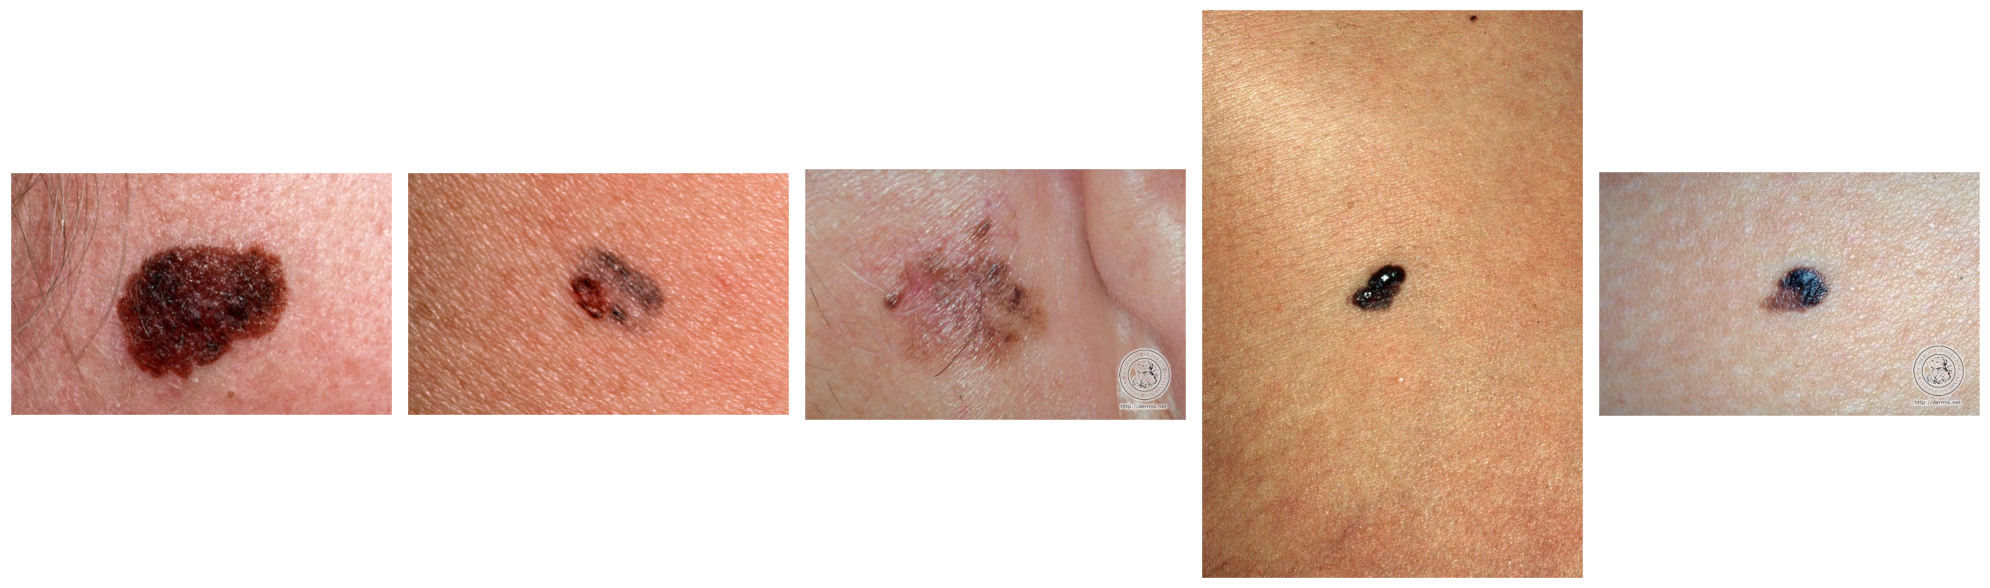

In [13]:
#plot sample images--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'images/'
    ax[i].imshow(load_img(path + img_path[i]))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()


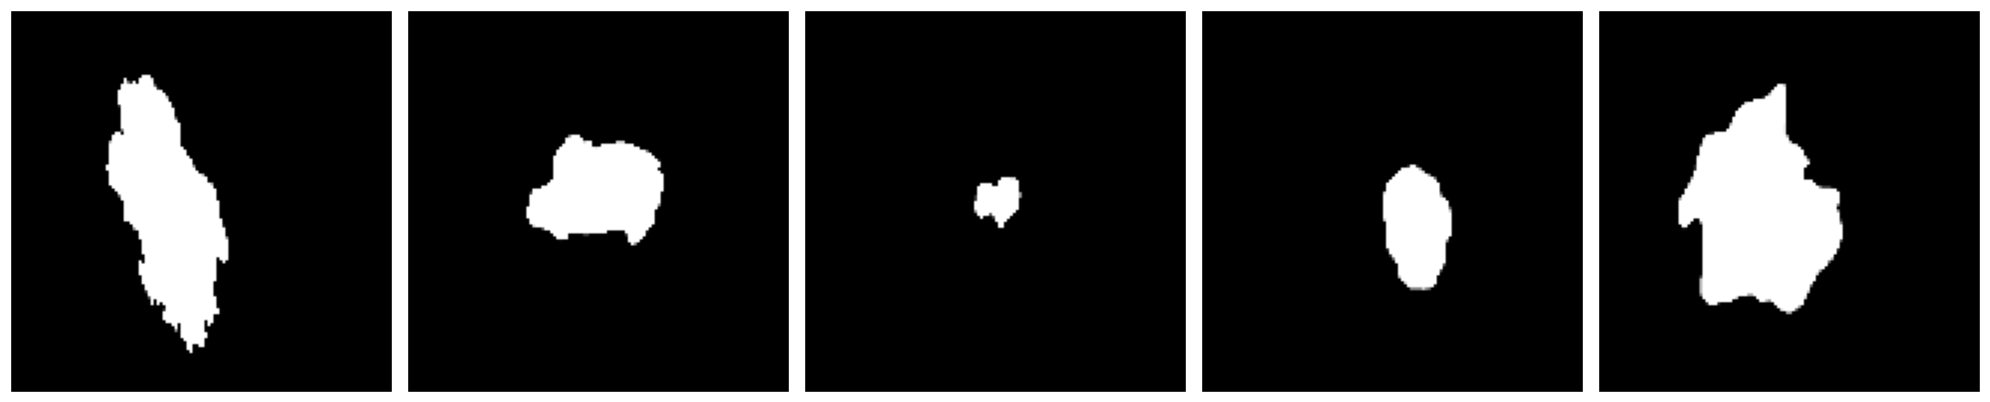

In [14]:
#plot sample masks--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'masks/'
    ax[i].imshow(cv_load_img(path + mask_path[i])[:, :, 0], 'gray')
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

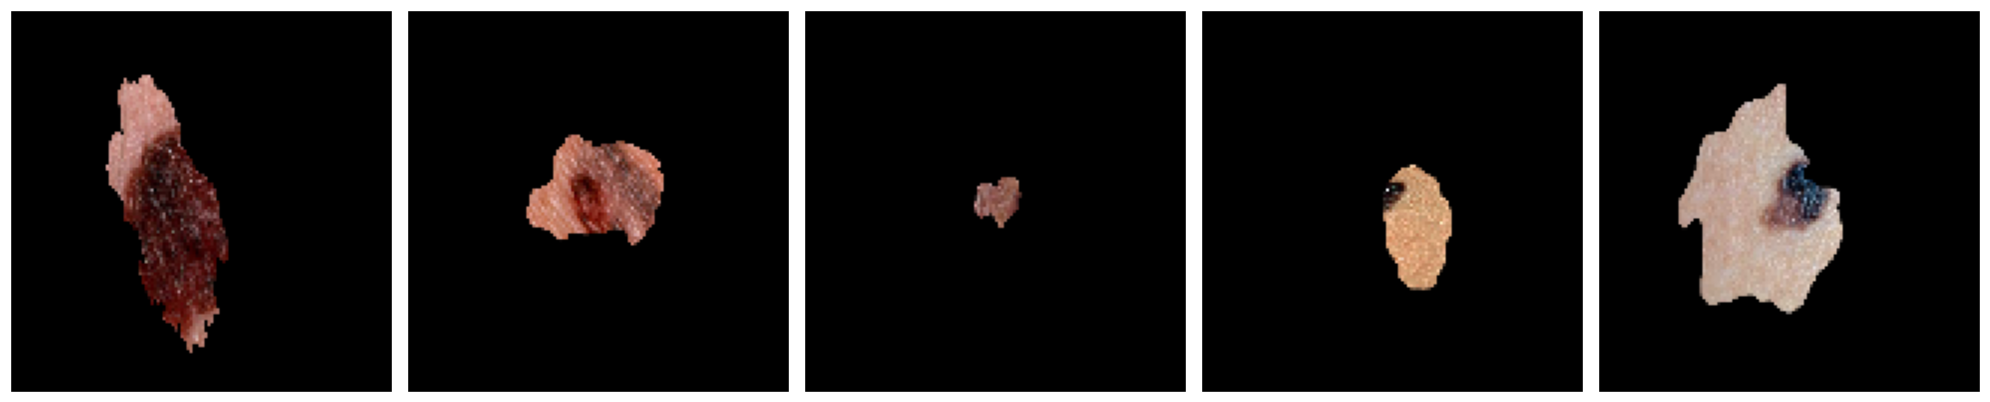

In [15]:
#plot sample images--with blended mask ------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path1= BASE_DIR + 'images/'
    ax[i].imshow((cv_load_img(path1 + img_path[i])/255) * (cv_load_img(path + mask_path[i])/255))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()


## **Augmented Images and Masks**

In [16]:
#data  preparation
X_train, X_test, y_train, y_test = train_test_split(img_path, mask_path, test_size=0.2, random_state=22)
len(X_train), len(X_test)


(95, 24)

In [17]:
#batch generation-----------------------
def load_data(path_list, gray=False):
    data=[]
    for path in tqdm(path_list):
        img= cv_load_img(path)
        if gray:
            img= img[:, :, 0:1]
        img= cv2.resize(img, (W, H))
        data.append(img)
    return np.array(data)


In [18]:
#train data generation---------------------
X_train= load_data([BASE_DIR + 'images/' + x for x in X_train])/255.0
X_test= load_data([BASE_DIR + 'images/' + x for x in X_test])/255.0


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [19]:
##test data generation---------------------
Y_train= load_data([BASE_DIR + 'masks/' + x for x in y_train], gray=True)/255.0
Y_test= load_data([BASE_DIR + 'masks/' + x for x in y_test], gray=True)/255.0
Y_train= Y_train.reshape(-1, W, H, 1)
Y_test= Y_test.reshape(-1, W, H, 1)

Y_train.shape, Y_test.shape

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

((95, 128, 128, 1), (24, 128, 128, 1))

## **Model UNet-Resnet34**

In [22]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_test)

## **Loss metrics**

In [23]:
# dice_loss metric
def dice_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true * y_true) + tf.reduce_sum(y_pred * y_pred) - tf.reduce_sum(y_true * y_pred)

    return 1 - numerator / denominator


In [24]:
#iou metric
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


In [25]:
#jacard_coef
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



## **Model configure**

In [45]:
# define model
model = Unet(BACKBONE, encoder_weights='imagenet',classes=1, input_shape=(H, W, CH),encoder_features='default',
             decoder_filters=(256, 128, 64, 32, 16)
            )
#loss = keras.losses.BinaryCrossentropy()
model.compile('Adam', loss=[bce_jaccard_loss,dice_loss], metrics=['accuracy', jacard_coef, iou])
#loss=[bce_jaccard_loss,dice_loss]

## **Model Summary**

In [ ]:
#Summary of model------------------
model.summary()

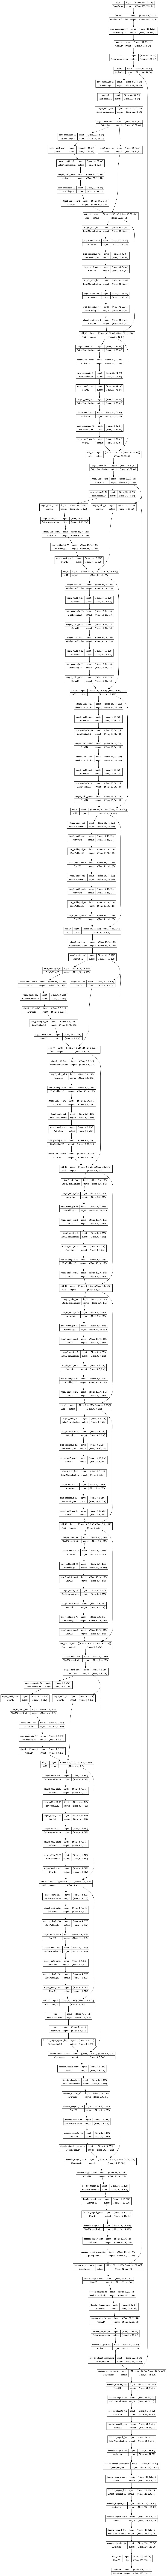

In [46]:
#Plot of model------------------
dot_img_file = 'model.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)


In [ ]:
#Train model---------------------------
nbatch_size=64
nepochs=200
history = model.fit(X_train,Y_train,batch_size=nbatch_size,
                    epochs=nepochs,validation_split=0.2,shuffle=True,
                    max_queue_size=32,workers=4,use_multiprocessing=True,                   
                   )

Epoch 1/200
2/2 [==============================] - 15s 3s/step - loss: 1.3911 - accuracy: 0.7736 - jacard_coef: 0.1459 - iou: 0.1464 - val_loss: 24.1621 - val_accuracy: 0.1058 - val_jacard_coef: 0.1010 - val_iou: 0.1013
Epoch 2/200
2/2 [==============================] - 15s 3s/step - loss: 1.3096 - accuracy: 0.8063 - jacard_coef: 0.2038 - iou: 0.2043 - val_loss: 45.3087 - val_accuracy: 0.1060 - val_jacard_coef: 0.1003 - val_iou: 0.1006
Epoch 3/200
2/2 [==============================] - 14s 3s/step - loss: 1.2601 - accuracy: 0.8516 - jacard_coef: 0.1854 - iou: 0.1860 - val_loss: 63.9064 - val_accuracy: 0.1064 - val_jacard_coef: 0.1002 - val_iou: 0.1005
Epoch 4/200
2/2 [==============================] - 14s 3s/step - loss: 1.2037 - accuracy: 0.8749 - jacard_coef: 0.1946 - iou: 0.1952 - val_loss: 77.0675 - val_accuracy: 0.1063 - val_jacard_coef: 0.1002 - val_iou: 0.1005
Epoch 5/200
2/2 [==============================] - 19s 3s/step - loss: 1.1527 - accuracy: 0.9034 - jacard_coef: 0.2246 -

2/2 [==============================] - 17s 4s/step - loss: 0.4513 - accuracy: 0.9661 - jacard_coef: 0.6224 - iou: 0.6233 - val_loss: 21.6255 - val_accuracy: 0.3559 - val_jacard_coef: 0.1286 - val_iou: 0.1290
Epoch 39/200
2/2 [==============================] - 19s 4s/step - loss: 0.4594 - accuracy: 0.9641 - jacard_coef: 0.5903 - iou: 0.5913 - val_loss: 25.4015 - val_accuracy: 0.3332 - val_jacard_coef: 0.1251 - val_iou: 0.1254
Epoch 40/200
2/2 [==============================] - 19s 4s/step - loss: 0.4540 - accuracy: 0.9648 - jacard_coef: 0.6162 - iou: 0.6171 - val_loss: 51.6587 - val_accuracy: 0.2826 - val_jacard_coef: 0.1184 - val_iou: 0.1187
Epoch 41/200
2/2 [==============================] - 19s 4s/step - loss: 0.4350 - accuracy: 0.9669 - jacard_coef: 0.6131 - iou: 0.6141 - val_loss: 54.2989 - val_accuracy: 0.2553 - val_jacard_coef: 0.1152 - val_iou: 0.1155
Epoch 42/200
2/2 [==============================] - 21s 5s/step - loss: 0.4251 - accuracy: 0.9669 - jacard_coef: 0.6503 - iou: 0.

2/2 [==============================] - 21s 4s/step - loss: 0.2115 - accuracy: 0.9830 - jacard_coef: 0.8292 - iou: 0.8296 - val_loss: 3.6251 - val_accuracy: 0.7164 - val_jacard_coef: 0.2522 - val_iou: 0.2528
Epoch 76/200
2/2 [==============================] - 21s 5s/step - loss: 0.2027 - accuracy: 0.9831 - jacard_coef: 0.8240 - iou: 0.8244 - val_loss: 3.7154 - val_accuracy: 0.7170 - val_jacard_coef: 0.2529 - val_iou: 0.2535
Epoch 77/200
2/2 [==============================] - 23s 5s/step - loss: 0.2101 - accuracy: 0.9824 - jacard_coef: 0.8299 - iou: 0.8303 - val_loss: 3.8816 - val_accuracy: 0.7245 - val_jacard_coef: 0.2586 - val_iou: 0.2593
Epoch 78/200
2/2 [==============================] - 19s 4s/step - loss: 0.2070 - accuracy: 0.9832 - jacard_coef: 0.8199 - iou: 0.8204 - val_loss: 3.5485 - val_accuracy: 0.7365 - val_jacard_coef: 0.2659 - val_iou: 0.2665
Epoch 79/200
2/2 [==============================] - 17s 4s/step - loss: 0.2080 - accuracy: 0.9829 - jacard_coef: 0.8356 - iou: 0.8359

## **Performance Plots**

In [48]:
df_result = pd.DataFrame(history.history)
df_result

loss  accuracy  jacard_coef       iou   val_loss  val_accuracy  \
0  1.731583  0.394823     0.118456  0.118906   4.792845      0.104325   
1  1.476318  0.683751     0.150526  0.151016  12.927203      0.105237   

   val_jacard_coef   val_iou  
0         0.106945  0.107251  
1         0.102116  0.102409

## **Visualize the model predictions**

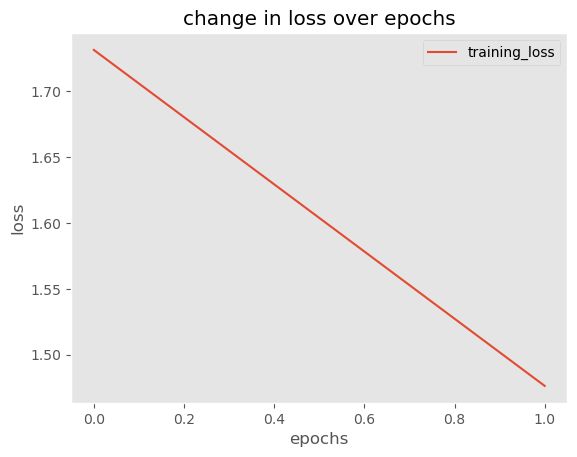

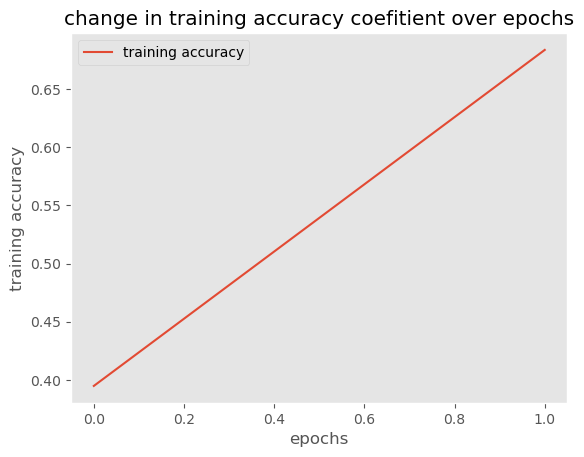

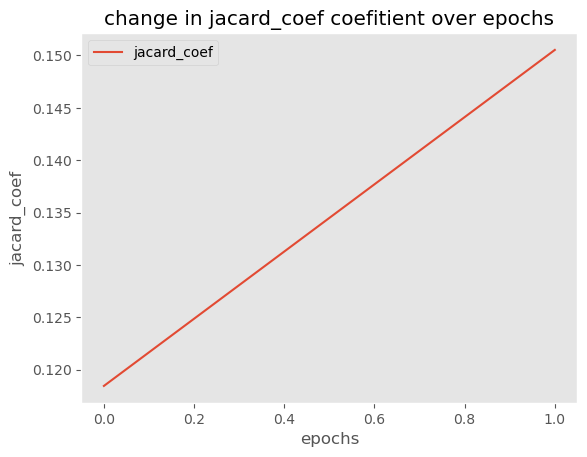

<Figure size 640x480 with 0 Axes>

In [49]:
# Plotting loss change over epochs---------------
nrange=nepochs
x = [i for i in range(nrange)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['training_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.axis('off')
plt.grid(None)
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['accuracy'])
plt.title('change in training accuracy coefitient over epochs')
plt.legend(['training accuracy'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.grid(None)
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['jacard_coef'])
plt.title('change in jacard_coef coefitient over epochs')
plt.legend(['jacard_coef'])
plt.xlabel('epochs')
plt.ylabel('jacard_coef')
plt.grid(None)
plt.show()
plt.tight_layout()


In [50]:
# Creating predictions on our test set-----------------
predictions = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [51]:
# create predictes mask--------------
def create_mask(predictions,input_shape=(W,H,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask

In [52]:
# Ploting results for one image----------------

def plot_results_for_one_sample(sample_index):
    
    mask = create_mask(predictions[sample_index])    
    fig = plt.figure(figsize=(20,20))
    #image
    fig.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(X_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #mask
    fig.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(Y_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #Predicted mask
    fig.add_subplot(1,4,3)
    plt.title('Predicted mask')  
    plt.imshow(mask)
    plt.axis('off')
    plt.grid(None)
    #Segment
    fig.add_subplot(1,4,4)
    plt.title("Segment image")
    plt.imshow(X_test[sample_index]*mask)
    plt.grid(None)
    plt.axis('off')  
    fig.tight_layout()
    


## **Model prediction**

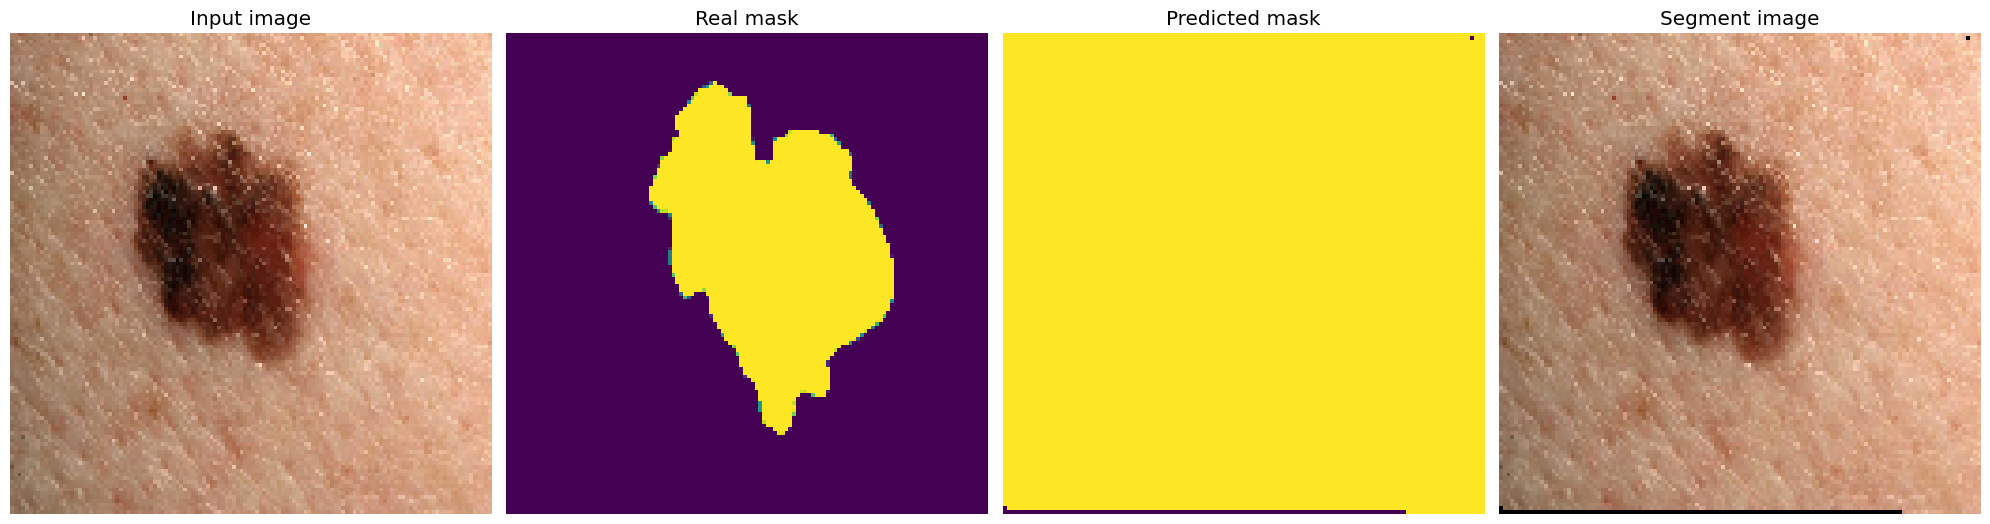

In [53]:
#Show predicted result---------------
plot_results_for_one_sample(0)


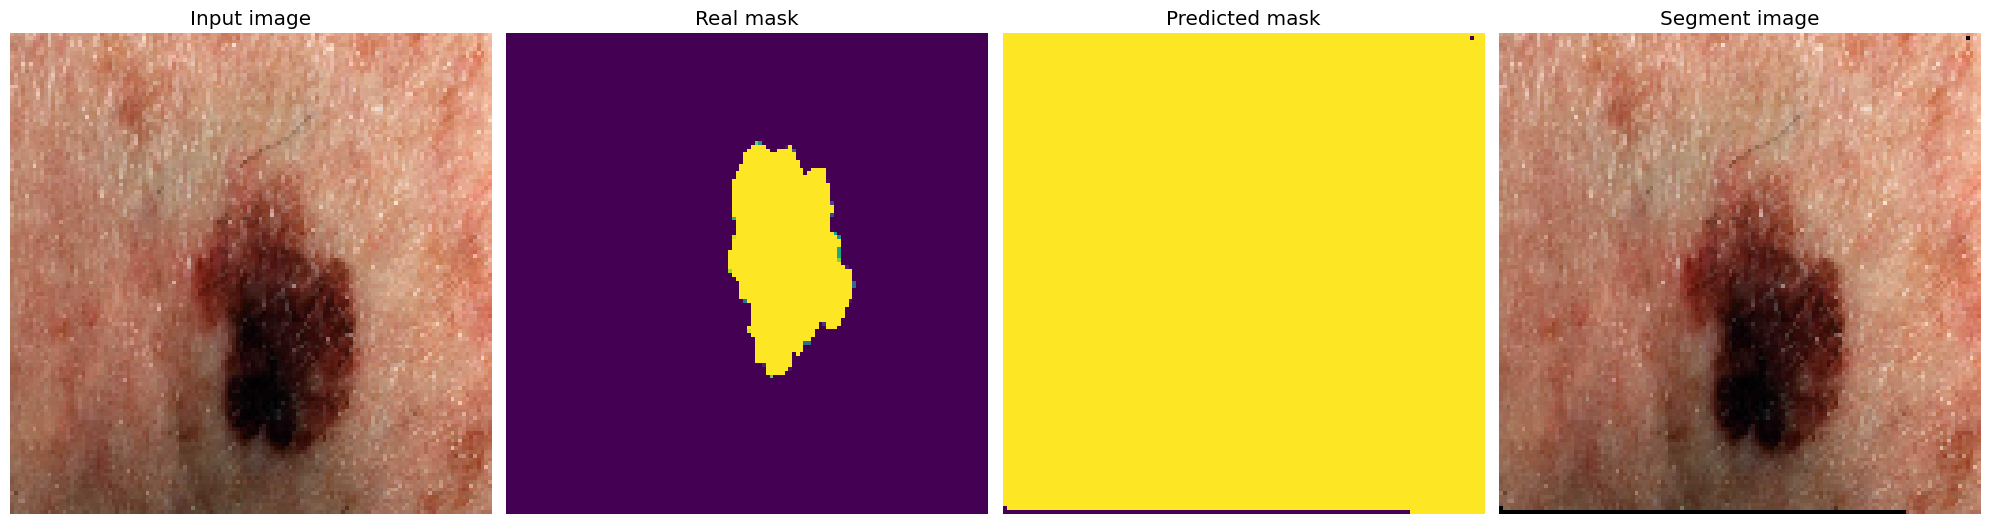

In [54]:
#Show predicted result---------------
plot_results_for_one_sample(1)


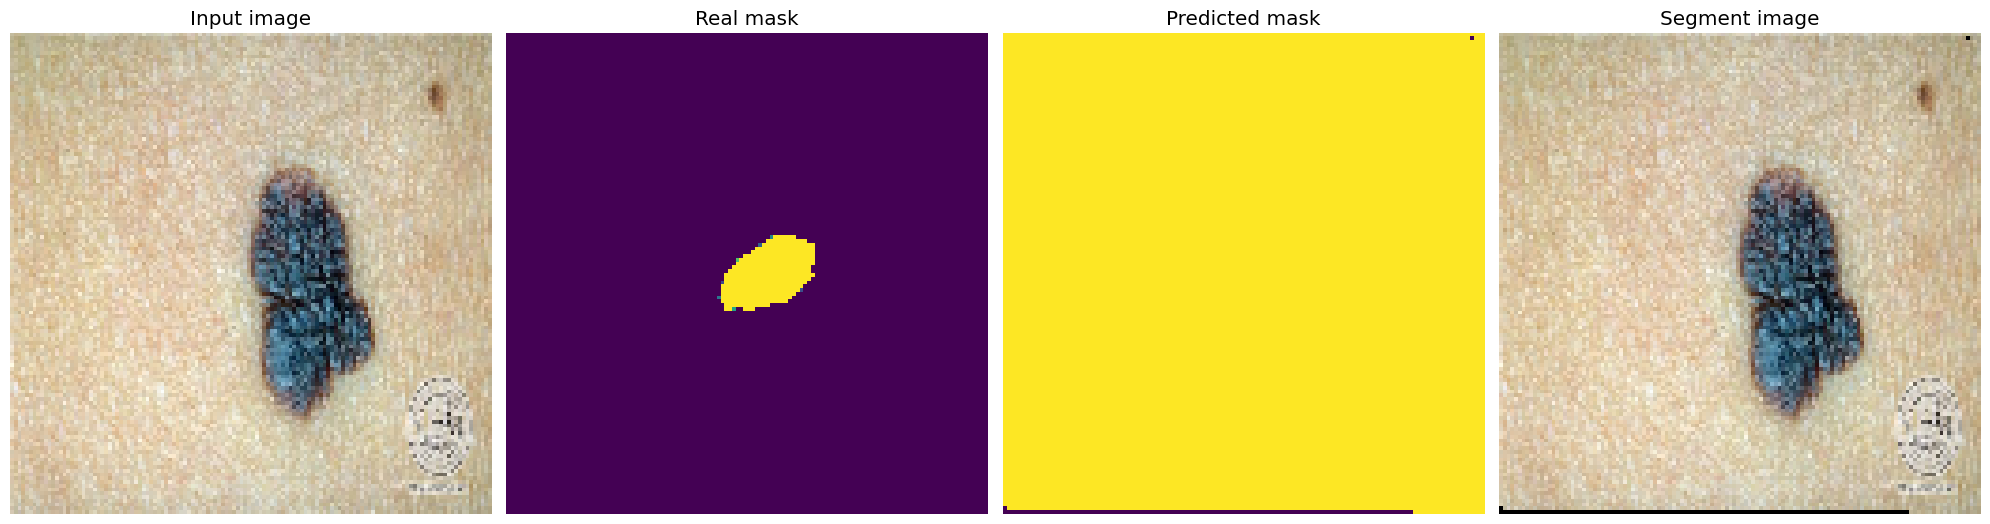

In [55]:
#Show predicted result---------------
plot_results_for_one_sample(2)

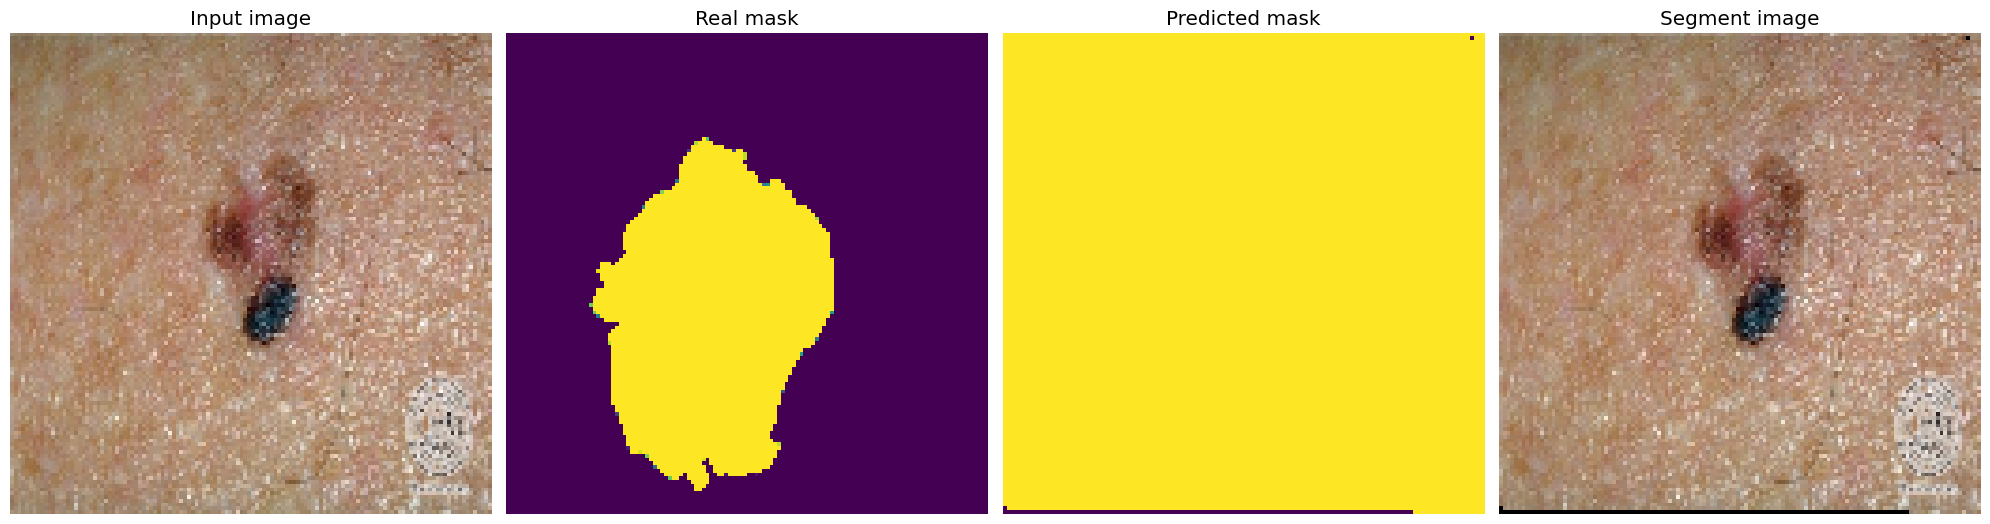

In [56]:
#Show predicted result---------------
plot_results_for_one_sample(3)


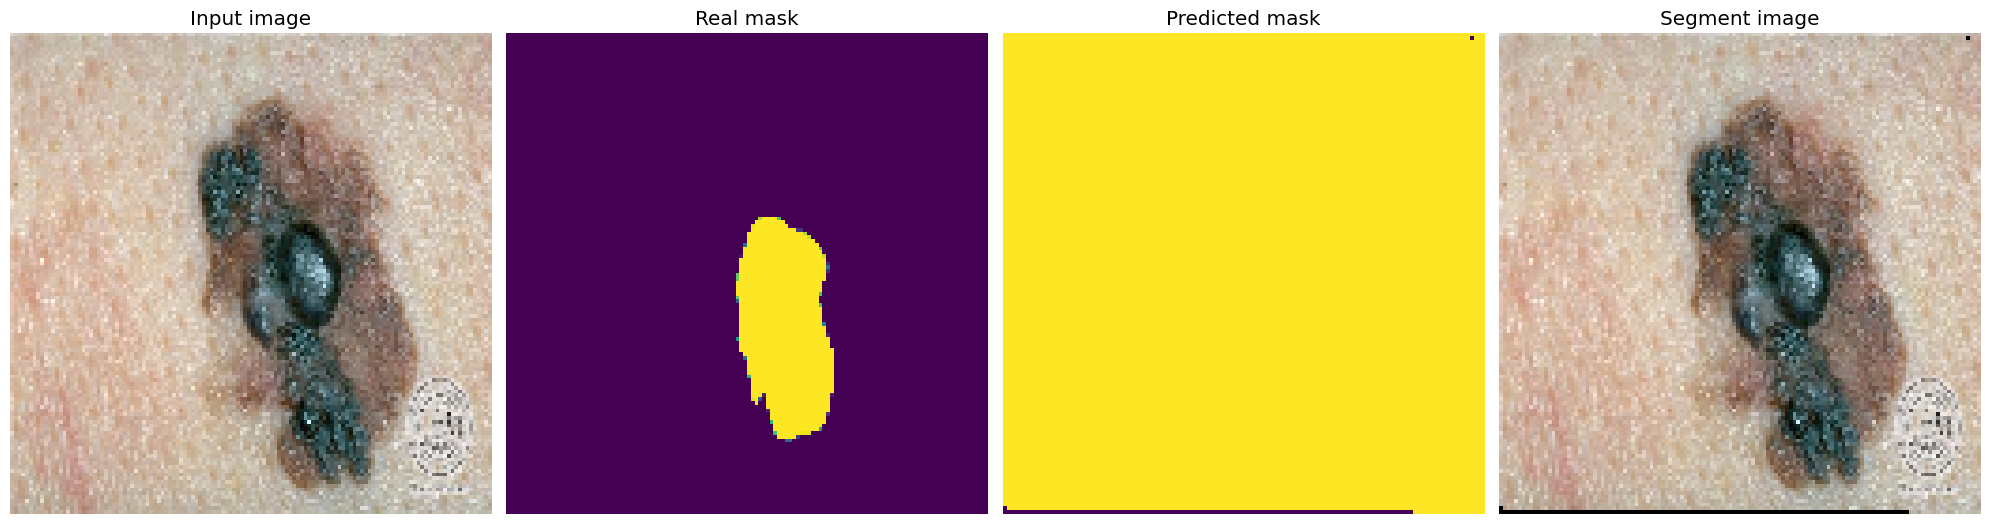

In [57]:
#Show predicted result---------------
plot_results_for_one_sample(4)


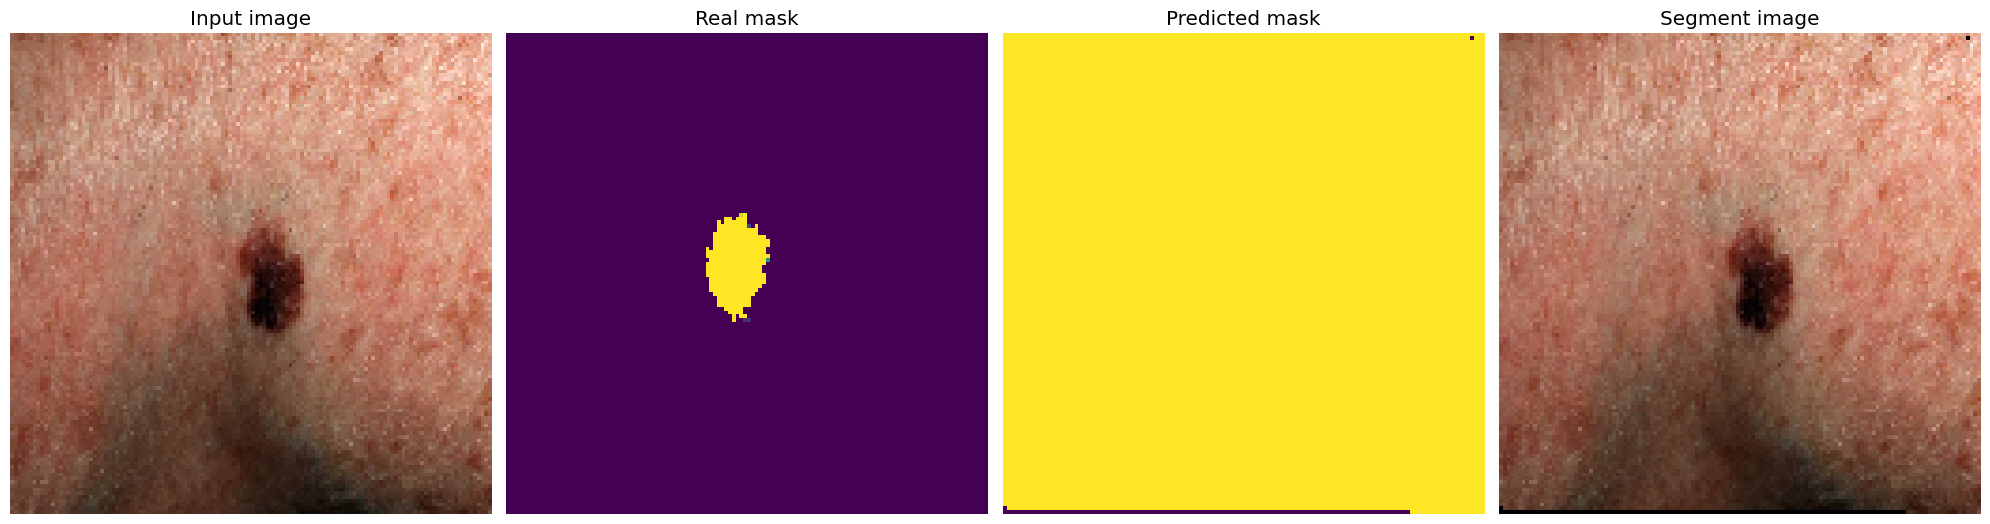

In [59]:
#Show predicted result---------------
plot_results_for_one_sample(5)


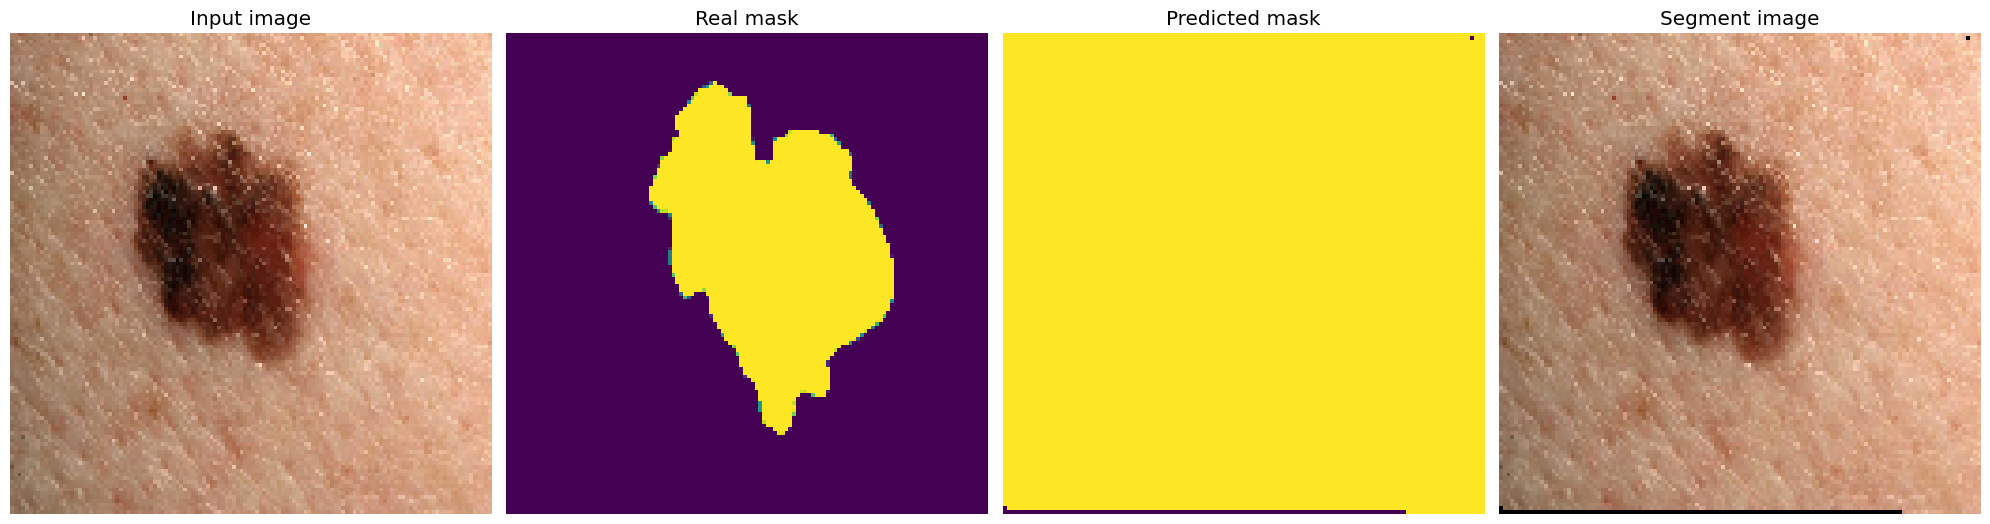

In [61]:
#Show predicted result---------------
plot_results_for_one_sample(0)
